In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 21/04/2022

    Code description :
    __________________
    Observes the recovery of a piecewise constant image from different observation models:
    partial Fourier sampling, denoising, and inpainting.
    
"""
import matplotlib.pyplot as plt
import numpy as np
from pyunlocbox import functions, solvers, acceleration
import imageio

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...

In [2]:
def PSNR(truth, approximation):
    MSE  = ((truth-approximation)**2).mean()
    PSNR = 10*np.log10(1**2/MSE)
    return PSNR

def show_result(I0, sol, I1=None, figsize=(12,5), ax2_label='', cmap='viridis'):
    fig = plt.figure(figsize=figsize)
    if (I1 is None):
        ax1 = fig.add_subplot(1, 2, 1)
        ax3 = fig.add_subplot(1, 2, 2)
    else:
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.imshow(I1, cmap=cmap)
        ax2.axis('off')
        ax2.set_title(ax2_label)
        ax3 = fig.add_subplot(1, 3, 3)

    ax1.imshow(I0, cmap=cmap)
    ax1.axis('off')
    ax1.set_title('Original image')
    ax3.imshow(sol, cmap=cmap)
    ax3.axis('off')
    ax3.set_title('Reconstructed image')
    plt.show()

In [8]:
# Load an image
image = 'f_ds.png' # 'cameraman.png'
I0 = imageio.imread(os.path.join(updir(os.getcwd(),2),'images/'+image)) / 255.
N = I0.shape[0]

<ipython-input-8-93a57aab7fb2>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I0 = imageio.imread(os.path.join(updir(os.getcwd(),2),'images/'+image)) / 255.


### Fourier recovery

solves :

$\text{min}_{\mathbf{x}}~\tau \lvert\lvert \mathbf{x}-\mathbf{y} \rvert\rvert_2^2 + \lvert\lvert\mathbf{x}\rvert\rvert_{\text{TV}}$ with $\mathbf y = \mathcal F \mathbf x$

Solution found after 42 iterations:
    objective function f(sol) = 5.259295e+02+5.777328e-03j
    stopping criterion: RTOL


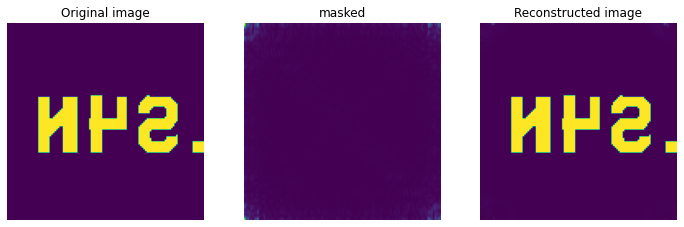

PSNR: 59.99


In [9]:
g = lambda x: T(x)
gt = lambda y: T_star(y).real
y = g(I0)
f1 = functions.norm_tv(maxit=50, dim=2)
tau = 100
f2 = functions.norm_l2(y=y, A=g, At=gt, lambda_=tau)
solver = solvers.forward_backward(step=0.5/tau)
x0 = np.copy(y)  # Make a copy to preserve im_masked.
ret1 = solvers.solve([f1, f2], x0, solver, maxit=100)

show_result(I0, np.abs(ret1['sol']), np.abs(y), ax2_label='masked')
print("PSNR: {:.2f}".format(PSNR(I0, ret1['sol'].real)))

### Forward-backward inpainting

solves :

$\text{min}_{\mathbf{x}}~\tau \lvert\lvert \mathbf{x}-\mathbf{y} \rvert\rvert_2^2 + \lvert\lvert\mathbf{x}\rvert\rvert_{\text{TV}}$ with $\mathbf y = \mathbf x_{\Omega} = \mathbf 1_\Omega * \mathbf x$

Solution found after 56 iterations:
    objective function f(sol) = 5.013734e+02
    stopping criterion: RTOL


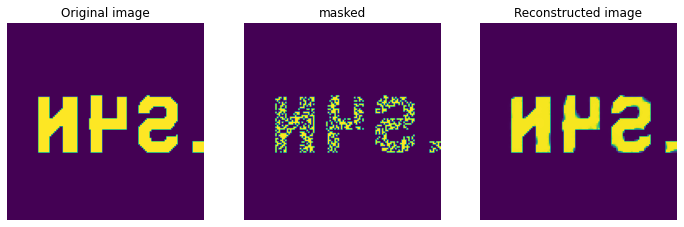

PSNR 12.488064628540743
PSNR 26.267070950194675


In [10]:
mask = np.random.uniform(size=I0.shape)
mask = mask > 0.5
g = lambda x: mask * x
im_masked = g(I0)
f1 = functions.norm_tv(maxit=50, dim=2)
tau = 100
f2 = functions.norm_l2(y=im_masked, A=g, lambda_=tau)
solver = solvers.forward_backward(step=0.5/tau)
x0 = np.array(im_masked)  # Make a copy to preserve im_masked.
ret1 = solvers.solve([f1, f2], x0, solver, maxit=100)

show_result(I0, ret1['sol'], im_masked, ax2_label='masked')

print("PSNR", PSNR(I0, im_masked))
print("PSNR", PSNR(I0, ret1['sol']))

### Forward-backward denoising

solves :

$\text{min}_{\mathbf{x}}~\tau \lvert\lvert \mathbf{x}-\mathbf{y} \rvert\rvert_2^2 + \lvert\lvert\mathbf{x}\rvert\rvert_{\text{TV}}$

Solution found after 2 iterations:
    objective function f(sol) = 2.256581e+03
    stopping criterion: RTOL


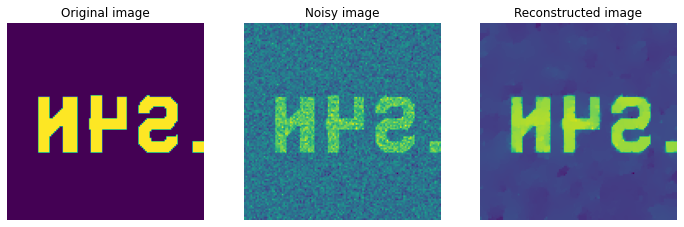

PSNR 12.034238525491446
PSNR 25.55200459511876


In [11]:
sigma = 0.25  # 0.08
I = I0 + np.random.normal(0, sigma, size=I0.shape)  # the amplitude of the noise

N = I.shape[0]

tau = 2 # 2
identity = lambda x: x
f2 = functions.norm_l2(y=I, A=identity, lambda_= tau)
f1 = functions.norm_tv(maxit=50, dim=2)

solver = solvers.forward_backward(step=0.5/tau, accel = acceleration.fista())
x0 = np.copy(I) # Initial guess
# x0=np.zeros(I0.shape)
ret2 = solvers.solve([f1, f2], x0, solver, maxit=10, rtol=1e-10) # rtol=None if go to maxit

show_result(I0, ret2['sol'], I, ax2_label='Noisy image')

print("PSNR", PSNR(I0, I))
print("PSNR", PSNR(I0, ret2['sol']))

### Douglas-Rachford method

Solves :

$\text{min}_{\mathbf{x}} \lvert\lvert\mathbf{x}\rvert\rvert_{\text{TV}}$ s.t. $\lvert\lvert \mathbf{x}-\mathbf{y} \rvert\rvert_2 \le \epsilon$

$f_1 (\mathbf{x}) = \lvert\lvert\mathbf{x}\rvert\rvert_{\text{TV}}$

$f_2 (\mathbf{x}) = I_{\mathcal{S}}(\mathbf{x})$ where $I_{\mathcal{S}}()$ is the indicator function of the set $\mathcal{S}={\mathbf{z} \in \mathcal{R}^n, \lvert\lvert \mathbf{z}-\mathbf{y} \rvert\rvert_2 \le \epsilon}$


c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\pyunlocbox\functions.py:623: RuntimeWarning: overflow encountered in power
  y += np.power(abs(g), 2)
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\pyunlocbox\functions.py:623: RuntimeWarning: overflow encountered in add
  y += np.power(abs(g), 2)
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\pyunlocbox\functions.py:719: RuntimeWarning: invalid value encountered in double_scalars
  rel_obj = np.abs(obj - prev_obj) / obj
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\pyunlocbox\solvers.py:294: RuntimeWarning: invalid value encountered in double_scalars
  relative = np.abs((current - last) / div)
c:\Users\leblanco.OASIS\Anaconda3\lib\site-packages\pyunlocbox\functions.py:999: RuntimeWarning: overflow encountered in multiply
  scale = s

Solution found after 200 iterations:
    objective function f(sol) = inf
    stopping criterion: MAXIT


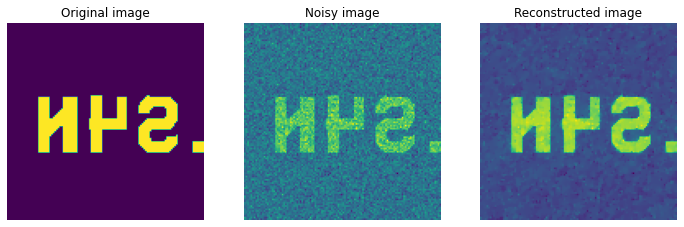

PSNR 12.034238525491446
PSNR -inf


<ipython-input-2-be9d495c3734>:2: RuntimeWarning: overflow encountered in square
  MSE  = ((truth-approximation)**2).mean()
<ipython-input-2-be9d495c3734>:3: RuntimeWarning: divide by zero encountered in log10
  PSNR = 10*np.log10(1**2/MSE)


In [12]:
f1 = functions.norm_tv(maxit=50, dim=2)
y = np.reshape(I, -1)  # Reshape the 2D image as a 1D vector.

epsilon = N * sigma           # Variance multiplied by N^2.
f = functions.proj_b2(y=y, epsilon=epsilon)
f2 = functions.func()
f2._eval = lambda x: 0        # Indicator functions evaluate to zero.

def prox(x, step):
    return np.reshape(f.prox(np.reshape(x, -1), 0), I.shape)
f2._prox = prox

solver = solvers.douglas_rachford(step=0.1)

x0 = np.copy(I) 
ret3 = solvers.solve([f1, f2], x0, solver)

show_result(I0, ret3['sol'], I, ax2_label='Noisy image')

print("PSNR", PSNR(I0, I))
print("PSNR", PSNR(I0, ret3['sol']))